[set/qpp-cpu] target=qpp-cpu platform=default simulator=qpp

[qpp-cpu] N=4 building args...
[qpp-cpu] N=4 warmup 1/1 ...
[qpp-cpu] N=4 rep 1/3 ... 0.0152s
 0.0148s] N=4 rep 2/3 ...
 0.0132s] N=4 rep 3/3 ...
[qpp-cpu] N=4 median=0.0148s (shots=200, steps=10)

[qpp-cpu] N=6 building args...
[qpp-cpu] N=6 warmup 1/1 ...
[qpp-cpu] N=6 rep 1/3 ... 6.0799s
 3.5679s] N=6 rep 2/3 ...
 4.1195s] N=6 rep 3/3 ...
[qpp-cpu] N=6 median=4.1195s (shots=200, steps=10)

[qpp-cpu] N=8 building args...
[qpp-cpu] N=8 warmup 1/1 ...
[qpp-cpu] N=8 rep 1/3 ... 28.8409s
 24.4432s N=8 rep 2/3 ...
 27.7621s N=8 rep 3/3 ...
[qpp-cpu] N=8 median=27.7621s (shots=200, steps=10)

[qpp-cpu] N=10 building args...
[qpp-cpu] N=10 warmup 1/1 ...
[qpp-cpu] N=10 rep 1/3 ... 64.0345s
 75.4842s N=10 rep 2/3 ...
 72.6025s N=10 rep 3/3 ...
[qpp-cpu] N=10 median=72.6025s (shots=200, steps=10)
[set/nvidia] target=nvidia platform=default simulator=cusvsim_fp32

[nvidia] N=4 building args...
[nvidia] N=4 warmup 1/1 ...
[nvidia] N=4

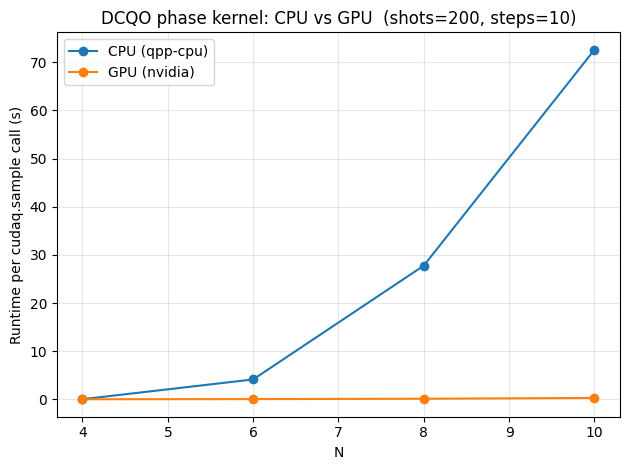

In [1]:
#!/usr/bin/env python3
"""
Standalone, copy-pasteable speedtest: SAME DCQO kernel on CPU (qpp-cpu) vs GPU (nvidia).

Why your run "hangs":
- You were doing MANY expensive cudaq.sample() calls per N (warmups + repeats).
- Full LABS cost has lots of terms; gate count grows fast with N, so N=10 can easily take minutes on qpp-cpu.
This script prints progress every repetition so it never goes silent.

Outputs:
  - speedtest_phase_dcqo_cpu_vs_gpu.csv
  - speedtest_phase_dcqo_cpu_vs_gpu.png
"""

import time
import csv
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt

import cudaq  # must be available

# ----------------------------
# USER TUNABLES (start small!)
# ----------------------------
N_LIST       = [4, 6, 8, 10]   # expand once stable
STEPS        = 10
DT           = 0.05
SHOTS        = 200             # keep modest for quick iteration
WARMUPS      = 1               # >=1 to pay JIT once
REPEATS      = 3               # keep small; increase once stable
COST_SCALE   = 0.05
CD_SCALE     = 0.1
MIX_SCALE    = 1.0

CPU_TARGET   = "qpp-cpu"
GPU_TARGET   = "nvidia"        # will fallback if unavailable
FALLBACKS    = ["qpp", "qpp-cpu"]

# ----------------------------
# Helpers / caches
# ----------------------------

@dataclass(frozen=True)
class LabsCostTerms:
    const: float
    pairs: List[Tuple[int, int, float]]
    quads: List[Tuple[int, int, int, int, float]]

@dataclass(frozen=True)
class CostArrays:
    pairs_i: List[int]
    pairs_j: List[int]
    pairs_w: List[float]
    quads_a: List[int]
    quads_b: List[int]
    quads_c: List[int]
    quads_d: List[int]
    quads_w: List[float]

    @property
    def num_pairs(self) -> int:
        return len(self.pairs_i)

    @property
    def num_quads(self) -> int:
        return len(self.quads_a)

_TERMS_CACHE: Dict[int, LabsCostTerms] = {}
_COST_CACHE: Dict[int, CostArrays] = {}
_CD_CACHE: Dict[int, Tuple[List[int], List[int], List[int], List[int], List[int], List[int]]] = {}
_SCHED_CACHE: Dict[Tuple[int, float], Tuple[List[float], List[float], float]] = {}
_THETA_CACHE: Dict[Tuple[int, float], List[float]] = {}
_KERNEL_CACHE: Dict[int, Any] = {}
_TARGET_LAST: Optional[str] = None

def _print_target(tag: str):
    t = cudaq.get_target()
    print(f"[{tag}] target={t.name} platform={t.platform} simulator={t.simulator}")

def _set_target_once(target: str):
    global _TARGET_LAST
    if _TARGET_LAST == target:
        return
    cudaq.set_target(target)
    _TARGET_LAST = target

def choose_target(preferred: str, fallbacks: List[str]) -> str:
    for tgt in [preferred] + list(fallbacks):
        if not tgt:
            continue
        try:
            cudaq.set_target(tgt)
            return tgt
        except Exception:
            continue
    raise RuntimeError(f"Could not set target: {preferred} (and fallbacks failed)")

def labs_cost_terms(n: int) -> LabsCostTerms:
    n = int(n)
    const = 0.0
    pair_map: Dict[Tuple[int, int], float] = {}
    quad_map: Dict[Tuple[int, int, int, int], float] = {}
    for k in range(1, n):
        m = n - k
        for i in range(m):
            for j in range(m):
                a, b = i, i + k
                c, d = j, j + k
                if i == j:
                    const += 1.0
                    continue
                idx = [a, b, c, d]
                counts: Dict[int, int] = {}
                for t in idx:
                    counts[t] = counts.get(t, 0) + 1
                remaining = []
                for t, ct in counts.items():
                    if ct % 2 == 1:
                        remaining.append(t)
                remaining.sort()
                if len(remaining) == 0:
                    const += 1.0
                elif len(remaining) == 2:
                    i1, i2 = remaining
                    if i1 > i2:
                        i1, i2 = i2, i1
                    pair_map[(i1, i2)] = pair_map.get((i1, i2), 0.0) + 1.0
                elif len(remaining) == 4:
                    key = tuple(remaining)  # type: ignore
                    quad_map[key] = quad_map.get(key, 0.0) + 1.0
                else:
                    raise RuntimeError("Unexpected remaining indices length.")
    pairs = [(i, j, float(w)) for (i, j), w in pair_map.items()]
    quads = [(a, b, c, d, float(w)) for (a, b, c, d), w in quad_map.items()]
    return LabsCostTerms(const=float(const), pairs=pairs, quads=quads)

def terms_to_cost_arrays(terms: LabsCostTerms) -> CostArrays:
    return CostArrays(
        pairs_i=[int(i) for (i, _, _) in terms.pairs],
        pairs_j=[int(j) for (_, j, _) in terms.pairs],
        pairs_w=[float(w) for (_, _, w) in terms.pairs],
        quads_a=[int(a) for (a, _, _, _, _) in terms.quads],
        quads_b=[int(b) for (_, b, _, _, _) in terms.quads],
        quads_c=[int(c) for (_, _, c, _, _) in terms.quads],
        quads_d=[int(d) for (_, _, _, d, _) in terms.quads],
        quads_w=[float(w) for (_, _, _, _, w) in terms.quads],
    )

def get_cost_arrays(n: int) -> CostArrays:
    n = int(n)
    if n in _COST_CACHE:
        return _COST_CACHE[n]
    if n not in _TERMS_CACHE:
        _TERMS_CACHE[n] = labs_cost_terms(n)
    _COST_CACHE[n] = terms_to_cost_arrays(_TERMS_CACHE[n])
    return _COST_CACHE[n]

def cd_interactions_lists(n: int) -> Tuple[List[int], List[int], List[int], List[int], List[int], List[int]]:
    n = int(n)
    g2_i: List[int] = []
    g2_j: List[int] = []
    g4_a: List[int] = []
    g4_b: List[int] = []
    g4_c: List[int] = []
    g4_d: List[int] = []
    for i0 in range(0, n - 2):
        kmax = (n - i0 - 1) // 2
        for k in range(1, kmax + 1):
            g2_i.append(i0)
            g2_j.append(i0 + k)
    for i0 in range(0, n - 3):
        tmax = (n - i0 - 2) // 2
        for t in range(1, tmax + 1):
            kmax = n - i0 - t - 1
            for k in range(t + 1, kmax + 1):
                g4_a.append(i0)
                g4_b.append(i0 + t)
                g4_c.append(i0 + k)
                g4_d.append(i0 + k + t)
    return g2_i, g2_j, g4_a, g4_b, g4_c, g4_d

def get_cd_lists(n: int):
    n = int(n)
    if n not in _CD_CACHE:
        _CD_CACHE[n] = cd_interactions_lists(n)
    return _CD_CACHE[n]

def get_schedule(steps: int, dt: float) -> Tuple[List[float], List[float], float]:
    key = (int(steps), float(dt))
    if key in _SCHED_CACHE:
        return _SCHED_CACHE[key]
    steps = int(steps); dt = float(dt)
    ttot = steps * dt
    gammas: List[float] = []
    betas: List[float] = []
    for p in range(steps):
        t_mid = (p + 0.5) * dt
        s = t_mid / ttot
        gammas.append(float(s))
        betas.append(float(1.0 - s))
    _SCHED_CACHE[key] = (gammas, betas, float(ttot))
    return _SCHED_CACHE[key]

def get_thetas(steps: int, dt: float, ttot: Optional[float] = None) -> List[float]:
    key = (int(steps), float(dt))
    if key in _THETA_CACHE:
        return _THETA_CACHE[key]
    if ttot is None:
        _, _, ttot = get_schedule(steps, dt)
    thetas: List[float] = []
    for p in range(int(steps)):
        t_mid = (p + 0.5) * float(dt)
        s = t_mid / float(ttot)
        thetas.append(float(dt) * float(s * (1.0 - s)))
    _THETA_CACHE[key] = thetas
    return thetas

def get_dcqo_kernel(n: int):
    n = int(n)
    if n in _KERNEL_CACHE:
        return _KERNEL_CACHE[n]

    @cudaq.kernel
    def dcqo_rt(
        cd_pi: list[int], cd_pj: list[int],
        cd_qa: list[int], cd_qb: list[int], cd_qc: list[int], cd_qd: list[int],
        cost_pi: list[int], cost_pj: list[int], cost_pw: list[float],
        cost_qa: list[int], cost_qb: list[int], cost_qc: list[int], cost_qd: list[int], cost_qw: list[float],
        gammas: list[float], betas: list[float], thetas: list[float],
        steps: int,
        num_cd_pairs: int, num_cd_quads: int,
        num_cost_pairs: int, num_cost_quads: int,
        cost_scale: float, cd_scale: float, mix_scale: float
    ):
        pio2 = 1.5707963267948966
        q = cudaq.qvector(n)
        h(q)

        for p in range(steps):
            beta = betas[p] * mix_scale
            gamma = gammas[p] * cost_scale
            theta = thetas[p] * cd_scale

            # mixing
            for qi in range(n):
                rx(2.0 * beta, q[qi])

            # cost (pairs)
            for t in range(num_cost_pairs):
                ii = cost_pi[t]; jj = cost_pj[t]; ww = cost_pw[t]
                phi = gamma * ww
                x.ctrl(q[ii], q[jj])
                rz(2.0 * phi, q[jj])
                x.ctrl(q[ii], q[jj])

            # cost (quads)
            for t in range(num_cost_quads):
                qa = cost_qa[t]; qb = cost_qb[t]; qc = cost_qc[t]; qd = cost_qd[t]; ww = cost_qw[t]
                phi = gamma * ww
                x.ctrl(q[qa], q[qd]); x.ctrl(q[qb], q[qd]); x.ctrl(q[qc], q[qd])
                rz(2.0 * phi, q[qd])
                x.ctrl(q[qc], q[qd]); x.ctrl(q[qb], q[qd]); x.ctrl(q[qa], q[qd])

            # CD (pairs)
            for t in range(num_cd_pairs):
                ii = cd_pi[t]; jj = cd_pj[t]
                rx(pio2, q[ii])
                x.ctrl(q[ii], q[jj]); rz(4.0 * theta, q[jj]); x.ctrl(q[ii], q[jj])
                rx(-pio2, q[ii])

                rx(pio2, q[jj])
                x.ctrl(q[ii], q[jj]); rz(4.0 * theta, q[jj]); x.ctrl(q[ii], q[jj])
                rx(-pio2, q[jj])

            # CD (quads): 4 orientations
            for t in range(num_cd_quads):
                qa = cd_qa[t]; qb = cd_qb[t]; qc = cd_qc[t]; qd = cd_qd[t]

                rx(pio2, q[qa])
                x.ctrl(q[qa], q[qd]); x.ctrl(q[qb], q[qd]); x.ctrl(q[qc], q[qd])
                rz(8.0 * theta, q[qd])
                x.ctrl(q[qc], q[qd]); x.ctrl(q[qb], q[qd]); x.ctrl(q[qa], q[qd])
                rx(-pio2, q[qa])

                rx(pio2, q[qb])
                x.ctrl(q[qa], q[qd]); x.ctrl(q[qb], q[qd]); x.ctrl(q[qc], q[qd])
                rz(8.0 * theta, q[qd])
                x.ctrl(q[qc], q[qd]); x.ctrl(q[qb], q[qd]); x.ctrl(q[qa], q[qd])
                rx(-pio2, q[qb])

                rx(pio2, q[qc])
                x.ctrl(q[qa], q[qd]); x.ctrl(q[qb], q[qd]); x.ctrl(q[qc], q[qd])
                rz(8.0 * theta, q[qd])
                x.ctrl(q[qc], q[qd]); x.ctrl(q[qb], q[qd]); x.ctrl(q[qa], q[qd])
                rx(-pio2, q[qc])

                rx(pio2, q[qd])
                x.ctrl(q[qa], q[qd]); x.ctrl(q[qb], q[qd]); x.ctrl(q[qc], q[qd])
                rz(8.0 * theta, q[qd])
                x.ctrl(q[qc], q[qd]); x.ctrl(q[qb], q[qd]); x.ctrl(q[qa], q[qd])
                rx(-pio2, q[qd])

        mz(q)

    _KERNEL_CACHE[n] = dcqo_rt
    return dcqo_rt

def prebuild_args(n: int):
    cost = get_cost_arrays(n)
    cdpi, cdpj, cdqa, cdqb, cdqc, cdqd = get_cd_lists(n)
    gammas, betas, ttot = get_schedule(STEPS, DT)
    thetas = get_thetas(STEPS, DT, ttot)
    ker = get_dcqo_kernel(n)
    args = (
        ker,
        cdpi, cdpj, cdqa, cdqb, cdqc, cdqd,
        cost.pairs_i, cost.pairs_j, cost.pairs_w,
        cost.quads_a, cost.quads_b, cost.quads_c, cost.quads_d, cost.quads_w,
        gammas, betas, thetas,
        int(STEPS),
        int(len(cdpi)), int(len(cdqa)),
        int(cost.num_pairs), int(cost.num_quads),
        float(COST_SCALE), float(CD_SCALE), float(MIX_SCALE),
    )
    return args

def time_one_target(target: str, n_list: List[int]) -> List[float]:
    _set_target_once(target)
    _print_target(f"set/{target}")

    out = []
    for n in n_list:
        print(f"\n[{target}] N={n} building args...")
        args = prebuild_args(n)

        # warmups (same shots path)
        for w in range(WARMUPS):
            print(f"[{target}] N={n} warmup {w+1}/{WARMUPS} ...")
            _ = cudaq.sample(*args, shots_count=int(SHOTS))

        # timed reps
        rep_times = []
        for r in range(REPEATS):
            print(f"[{target}] N={n} rep {r+1}/{REPEATS} ...", end="", flush=True)
            t0 = time.perf_counter()
            _ = cudaq.sample(*args, shots_count=int(SHOTS))
            dt = time.perf_counter() - t0
            rep_times.append(dt)
            print(f" {dt:.4f}s")

        med = float(np.median(rep_times))
        print(f"[{target}] N={n} median={med:.4f}s (shots={SHOTS}, steps={STEPS})")
        out.append(med)

    return out

def main():
    # CPU sweep
    cpu_tgt = choose_target(CPU_TARGET, FALLBACKS)
    cpu_times = time_one_target(cpu_tgt, N_LIST)

    # GPU sweep
    gpu_tgt = choose_target(GPU_TARGET, FALLBACKS)
    gpu_times = time_one_target(gpu_tgt, N_LIST)

    rows = [{"N": int(n), "cpu_s": float(tc), "gpu_s": float(tg), "cpu_target": cpu_tgt, "gpu_target": gpu_tgt}
            for n, tc, tg in zip(N_LIST, cpu_times, gpu_times)]

    out_csv = "speedtest_phase_dcqo_cpu_vs_gpu.csv"
    with open(out_csv, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
        w.writeheader()
        w.writerows(rows)
    print(f"\nWrote {out_csv}")

    # Plot
    Ns = np.array([r["N"] for r in rows], dtype=int)
    cpu = np.array([r["cpu_s"] for r in rows], dtype=float)
    gpu = np.array([r["gpu_s"] for r in rows], dtype=float)

    plt.figure()
    plt.plot(Ns, cpu, marker="o", label=f"CPU ({cpu_tgt})")
    plt.plot(Ns, gpu, marker="o", label=f"GPU ({gpu_tgt})")
    plt.xlabel("N")
    plt.ylabel("Runtime per cudaq.sample call (s)")
    plt.title(f"DCQO phase kernel: CPU vs GPU  (shots={SHOTS}, steps={STEPS})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    out_png = "speedtest_phase_dcqo_cpu_vs_gpu.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    print(f"Wrote {out_png}")

    print("\nDone.")

if __name__ == "__main__":
    main()
